# Industrial Audio - Classification Model
#### Illustrated with LAX Airplane Landing - Binary Classifier 
Last Updated October 14, 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
import seaborn as sns
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import MaxPooling3D, Flatten, Conv3D
from keras import backend as K
from keras.layers import LeakyReLU,PReLU
import keras
from keras.losses import *
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math
from pydub import AudioSegment
from pydub.playback import play
import specAugment
# from specAugment import spec_augment_tensorflow

Using TensorFlow backend.


In [2]:
# os.chdir("D:\\aircraft-audio\lax-naming-convention")
# import IPython
# from IPython.display import Image, Audio
# print("Embraer")
# Image(filename='embardier.png',width=300, height=200)

### Load and Inspect Data

In [3]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.

os.chdir("D:\\aircraft-audio\\local-data")
print(os.getcwd())

Boeing_slices_train_matrix = np.loadtxt('Boeing_slices_train_matrix.txt', delimiter=',')
Boeing_slices_test_matrix = np.loadtxt('Boeing_slices_test_matrix.txt', delimiter=',')
Embraer_slices_train_matrix = np.loadtxt('Embraer_slices_train_matrix.txt', delimiter=',')
Embraer_slices_test_matrix = np.loadtxt('Embraer_slices_test_matrix.txt', delimiter=',')
Bombardier_slices_train_matrix = np.loadtxt('Bombardier_slices_train_matrix.txt', delimiter=',')
Bombardier_slices_test_matrix = np.loadtxt('Bombardier_slices_test_matrix.txt', delimiter=',')
Airbus_slices_train_matrix = np.loadtxt('Airbus_slices_train_matrix.txt', delimiter=',')
Airbus_slices_test_matrix = np.loadtxt('Airbus_slices_test_matrix.txt', delimiter=',')
#Other_slices_train_matrix = np.loadtxt('Other_slices_train_matrix.txt', delimiter=',')
#Other_slices_test_matrix = np.loadtxt('Other_slices_test_matrix.txt', delimiter=',')   

D:\aircraft-audio\local-data


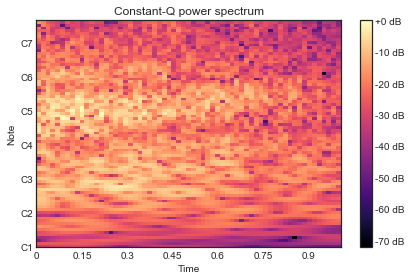

In [4]:
import librosa.display
import matplotlib.pyplot as plt
C = np.abs(librosa.cqt(Boeing_slices_train_matrix[20,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=80, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

[ 2199.  2209.  6063. ... 11358. 12196. 11676.]


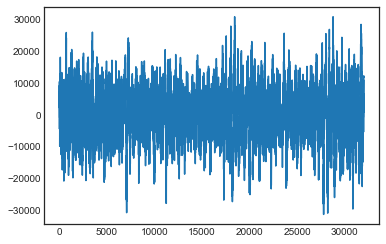

In [5]:
signal = Boeing_slices_train_matrix[40,:]
time = 32000
print(signal)
plt.plot(signal)
plt.show()

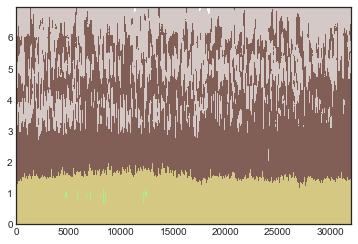

In [6]:
# Sample Continuous Waveleet Spectrogram
scales = np.arange(1,128)
time = np.arange(0,32000)
dt = time[1] - time[0]
wavelet = 'cmor1.5-1.0'

# Generate coefficients and frequencies
[cfs, frequencies] = pywt.cwt(signal, scales, wavelet, dt)

# Manipulate for spectrogram
power = (abs(cfs)) ** 2
period = 1. / frequencies
#levels = 
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
NewLevels = np.log2(levels)

X = time
Y = np.log2(period)
Z = np.log2(power)

plt.contourf(X, Y, Z, extend = 'both',cmap='terrain')
#plt.colorbar();


### Add Augmented Data

In [7]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [8]:
# Create Augmented matrices with volume reduction
Boeing_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Boeing_slices_train_matrix, -5)
Embraer_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Embraer_slices_train_matrix, -5)
Bombardier_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Bombardier_slices_train_matrix, -5)
Airbus_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Airbus_slices_train_matrix, -5)
#Other_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Other_slices_train_matrix, -8)

In [9]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [10]:
# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.005)
Boeing_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Boeing_slices_train_matrix,0.005)
Bombardier_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Bombardier_slices_train_matrix,0.005)
Airbus_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Airbus_slices_train_matrix,0.005)
#Other_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Other_slices_train_matrix,0.005)

In [11]:
# spec augment function 
# https://github.com/shelling203/SpecAugment
    
#     mel_spectrogram = librosa.feature.melspectrogram(y=Embraer_slices_train_matrix[0,:],
#                                                      sr=sampling_rate,
#                                                      n_mels=256,
#                                                      hop_length=64,
#                                                      fmax=8000)

### Add Labels

In [12]:
#Source Data Matrices

Boeing_slices_train_matrix = np.c_[ np.ones(len(Boeing_slices_train_matrix)),Boeing_slices_train_matrix] 
Boeing_slices_train_matrix[:, 0] =  0
print(Boeing_slices_train_matrix.shape)

Boeing_slices_test_matrix = np.c_[ np.ones(len(Boeing_slices_test_matrix)),Boeing_slices_test_matrix] 
Boeing_slices_test_matrix[:, 0] =  0
print(Boeing_slices_test_matrix.shape)

Embraer_slices_train_matrix = np.c_[ np.ones(len(Embraer_slices_train_matrix)),Embraer_slices_train_matrix] 
Embraer_slices_train_matrix[:, 0] = 1
print(Embraer_slices_train_matrix.shape)

Embraer_slices_test_matrix = np.c_[ np.ones(len(Embraer_slices_test_matrix)),Embraer_slices_test_matrix] 
Embraer_slices_test_matrix[:, 0] =  1
print(Embraer_slices_test_matrix.shape)

Bombardier_slices_train_matrix = np.c_[ np.ones(len(Bombardier_slices_train_matrix)),Bombardier_slices_train_matrix] 
Bombardier_slices_train_matrix[:, 0] = 1
print(Bombardier_slices_train_matrix.shape)

Bombardier_slices_test_matrix = np.c_[ np.ones(len(Bombardier_slices_test_matrix)),Bombardier_slices_test_matrix] 
Bombardier_slices_test_matrix[:, 0] =  1
print(Bombardier_slices_test_matrix.shape)

Airbus_slices_train_matrix = np.c_[ np.ones(len(Airbus_slices_train_matrix)),Airbus_slices_train_matrix] 
Airbus_slices_train_matrix[:, 0] = 0
print(Embraer_slices_train_matrix.shape)

Airbus_slices_test_matrix = np.c_[ np.ones(len(Airbus_slices_test_matrix)),Airbus_slices_test_matrix] 
Airbus_slices_test_matrix[:, 0] =  0
print(Airbus_slices_test_matrix.shape)

#Other_slices_train_matrix = np.c_[ np.ones(len(Other_slices_train_matrix)),Other_slices_train_matrix] 
#Other_slices_train_matrix[:, 0] = 0
#print(Other_slices_train_matrix.shape)

#Other_slices_test_matrix = np.c_[ np.ones(len(Other_slices_test_matrix)),Other_slices_test_matrix] 
#Other_slices_test_matrix[:, 0] =  0
#print(Other_slices_test_matrix.shape)



(67, 32001)
(50, 32001)
(34, 32001)
(23, 32001)
(39, 32001)
(24, 32001)
(34, 32001)
(19, 32001)


In [13]:
#Augmented Matrices

Boeing_augmented_train_matrix = np.c_[ np.ones(len(Boeing_augmented_train_matrix)),Boeing_augmented_train_matrix] 
Boeing_augmented_train_matrix[:, 0] = 0
Boeing_augmented_train_matrix = np.delete(Boeing_augmented_train_matrix, (0), axis=0)
print(Boeing_augmented_train_matrix.shape)

Embraer_augmented_train_matrix = np.c_[ np.ones(len(Embraer_augmented_train_matrix)),Embraer_augmented_train_matrix] 
Embraer_augmented_train_matrix[:, 0] = 1
Embraer_augmented_train_matrix = np.delete(Embraer_augmented_train_matrix, (0), axis=0)
print(Embraer_augmented_train_matrix.shape)

Bombardier_augmented_train_matrix = np.c_[ np.ones(len(Bombardier_augmented_train_matrix)),Bombardier_augmented_train_matrix] 
Bombardier_augmented_train_matrix[:, 0] =1
Bombardier_augmented_train_matrix = np.delete(Bombardier_augmented_train_matrix, (0), axis=0)
print(Bombardier_augmented_train_matrix.shape)

Airbus_augmented_train_matrix = np.c_[ np.ones(len(Airbus_augmented_train_matrix)),Airbus_augmented_train_matrix] 
Airbus_augmented_train_matrix[:, 0] = 0
Airbus_augmented_train_matrix = np.delete(Airbus_augmented_train_matrix, (0), axis=0)
print(Airbus_augmented_train_matrix.shape)

#Other_augmented_train_matrix = np.c_[ np.ones(len(Other_augmented_train_matrix)),Other_augmented_train_matrix] 
#Other_augmented_train_matrix[:, 0] = 0
#Other_augmented_train_matrix = np.delete(Other_augmented_train_matrix, (0), axis=0)
#print(Other_augmented_train_matrix.shape)

Boeing_augmented_train_matrix2 = np.c_[ np.ones(len(Boeing_augmented_train_matrix2)),Boeing_augmented_train_matrix2] 
Boeing_augmented_train_matrix2[:, 0] = 0
Boeing_augmented_train_matrix2 = np.delete(Boeing_augmented_train_matrix2, (0), axis=0)
print(Boeing_augmented_train_matrix2.shape)

Embraer_augmented_train_matrix2 = np.c_[ np.ones(len(Embraer_augmented_train_matrix2)),Embraer_augmented_train_matrix2] 
Embraer_augmented_train_matrix2[:, 0] = 1
Embraer_augmented_train_matrix2 = np.delete(Embraer_augmented_train_matrix2, (0), axis=0)
print(Embraer_augmented_train_matrix2.shape)

Bombardier_augmented_train_matrix2 = np.c_[ np.ones(len(Bombardier_augmented_train_matrix2)),Bombardier_augmented_train_matrix2] 
Bombardier_augmented_train_matrix2[:, 0] = 1
Bombardier_augmented_train_matrix2 = np.delete(Bombardier_augmented_train_matrix2, (0), axis=0)
print(Bombardier_augmented_train_matrix2.shape)

Airbus_augmented_train_matrix2 = np.c_[ np.ones(len(Airbus_augmented_train_matrix2)),Airbus_augmented_train_matrix2] 
Airbus_augmented_train_matrix2[:, 0] = 0
Airbus_augmented_train_matrix2 = np.delete(Airbus_augmented_train_matrix2, (0), axis=0)
print(Airbus_augmented_train_matrix2.shape)

#Other_augmented_train_matrix2 = np.c_[ np.ones(len(Other_augmented_train_matrix2)),Other_augmented_train_matrix2] 
#Other_augmented_train_matrix2[:, 0] = 0
#Other_augmented_train_matrix2 = np.delete(Other_augmented_train_matrix2, (0), axis=0)
#print(Other_augmented_train_matrix2.shape)



(67, 32001)
(34, 32001)
(39, 32001)
(37, 32001)
(67, 32001)
(34, 32001)
(39, 32001)
(37, 32001)


### Split and Shuffle Data

In [14]:
all_train_data = []

In [15]:
all_train_data = np.append(Boeing_slices_train_matrix, Embraer_slices_train_matrix, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Bombardier_slices_train_matrix, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Airbus_slices_train_matrix, axis=0)
print(all_train_data.shape)
#all_train_data = np.append(all_train_data ,Other_slices_train_matrix, axis=0)
#print(all_train_data.shape)


(101, 32001)
(140, 32001)
(177, 32001)


In [16]:

# Add augmented data just to training matrix
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix2, axis=0)
#all_train_data = np.append(all_train_data ,Other_augmented_train_matrix, axis=0)
#all_train_data = np.append(all_train_data ,Other_augmented_train_matrix2, axis=0)
print(all_train_data.shape)

(531, 32001)


In [17]:
# # Triple the Bombardier samples
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix2, axis=0)


In [18]:
all_test_data = np.append(Boeing_slices_test_matrix, Embraer_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data, Bombardier_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data , Airbus_slices_test_matrix,axis=0)
print(all_test_data.shape)

np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

y_train = np.asarray(all_train_data[:,0])
X_train = np.asarray(all_train_data[:,1:32001])

y_test = np.asarray(all_test_data[:,0])
X_test = np.asarray(all_test_data[:,1:32001])

(116, 32001)


In [19]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(609,)
(609, 32000)
(116,)
(116, 32000)


In [20]:
trainsize = len(y_train)
print(trainsize)
testsize = len(y_test)
print(testsize)

609
116


### Save Intermediary Files

In [21]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [22]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_test.any(axis=1))[0]

### Slicing and Featurizing

In [23]:
mfcc_data = []

In [24]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [25]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [26]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [27]:
# Function to generate continuous wavelet transforms
def plot_wavelet(time, signal):
    scales = np.arange(1,32)
    time = np.arange(0,32000)
    dt = time[1] - time[0]
    wavelet = 'cmor1.5-1.0'
    
    # Generate coefficients and frequencies
    [cfs, frequencies] = pywt.cwt(signal, scales, wavelet, dt)
    
    # Manipulate for image
    power = (abs(cfs)) ** 2
    period = 1. / frequencies 
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    NewLevels = np.log2(levels)
    
    X = time
    Y = np.log2(period)
    Z = np.log2(power)
    
    plotmatrix = plt.contourf(X, Y, Z, extend = 'both',cmap='terrain')

    plotmatrix = np.array(plotmatrix)
    print(X.shape)
    print(Y.shape)
    print(Z.shape)
    


(32000,)
(31,)
(31, 32000)


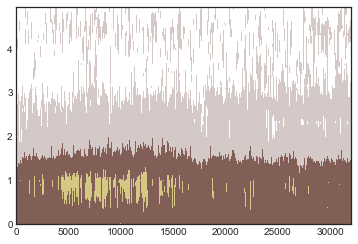

In [28]:
plot_wavelet(time,signal)

In [29]:
train_data_cwt = 0
import tkinter
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure


In [30]:
# # Continuous wavelet transform

# os.chdir("D:\\aircraft-audio\\Test_cwt")

# # Define vars
# scales = np.arange(1,32)
# time = np.arange(0,500)
# timelength = len(time)
# dt = time[1] - time[0]
# waveletname = 'shan' #'cmor1.5-1.0' shan
# levels = [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2,4]
# NewLevels = np.log2(levels)

# for ii in range(0,testsize):
#         signal = all_test_data[ii, 10000:10500]
#         coeff, freq = pywt.cwt(signal, scales, waveletname, 1)

#         # Manipulate for spectrogram
#         power = (abs(coeff)) ** 2   #output 2D     
#         period = 1. / freq  
#         X = time
#         Y = np.log2(period)
#         Z = np.log2(power)
        
#         # Create continuous wavelet transform
#         plt.contourf(X, Y, Z, extend = 'both',cmap='terrain')
#         plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#         plt.axis('off')
#         imgpath = 'image' + str(ii) + '.png'
#         savedimage = plt.savefig('image' + '-'+ str(ii) + '.png')
        

In [31]:
# # Continuous wavelet transform
# os.chdir("D:\\aircraft-audio\\Train_cwt")

# # Define vars
# scales = np.arange(1,32)
# time = np.arange(0,500)
# timelength = len(time)
# dt = time[1] - time[0]
# waveletname = 'shan' #'cmor1.5-1.0'
# levels = [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2,4]
# NewLevels = np.log2(levels)

# for ii in range(0,trainsize):
#         signal = all_train_data[ii, 10000:10500]
#         coeff, freq = pywt.cwt(signal, scales, waveletname, 1)

#         # Manipulate for image
#         power = (abs(coeff)) ** 2   #output 2D     
#         period = 1. / freq  
#         X = time
#         Y = np.log2(period)
#         Z = np.log2(power)
        
#         # Create continuous wavelet transform
#         plt.contourf(X, Y, Z, extend = 'both',cmap='terrain')
#         plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#         plt.axis('off')
#         imgpath = 'image' + str(ii) + '.png'
#         savedimage = plt.savefig('image' + '-'+ str(ii) + '.png')     

In [32]:
                      
import cv2
import glob
import numpy as np
os.chdir("D:\\aircraft-audio\\Train_cwt")
train_data_cwt = []
files = glob.glob ("*.png")
for myFile in files:
    image = cv2.imread (myFile)
    train_data_cwt.append (image)

print('train_data_cwt shape:', np.array(train_data_cwt).shape)
train_data_cwt_array = np.array(train_data_cwt)

train_data_cwt shape: (599, 288, 432, 3)


In [33]:
import cv2
import glob
import numpy as np
os.chdir("D:\\aircraft-audio\\Test_cwt")
test_data_cwt = []
files = glob.glob ("*.png")
for myFile in files:
    image = cv2.imread (myFile)
    test_data_cwt.append (image)

print('test_data_cwt shape:', np.array(test_data_cwt).shape)
test_data_cwt_array = np.array(test_data_cwt)

test_data_cwt shape: (116, 288, 432, 3)


In [34]:
print(train_data_cwt_array.shape)
print(test_data_cwt_array.shape)
print(trainsize)
print(testsize)

(599, 288, 432, 3)
(116, 288, 432, 3)
609
116


In [35]:
print(X.shape)
print(Y.shape)

(32000,)
(127,)


In [36]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    index = 0
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])
        # stft_data = librosa.core.stft(convert_audio_i2f(raw_data))
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        constant_q_shape_1 = constant_q.shape[1]
        constant_q_shape_0 = constant_q.shape[0]
        primary_input.append(constant_q)
        
    primary_input = np.array(primary_input).reshape(-1, constant_q_shape_0, constant_q_shape_1, 1)
    print(primary_input.shape)

    for rows in range(0,row_count):
        freq = fundamental_freq_gen(data[rows,:])
        index = index + 1
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, 11)
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print(normalized_crepe_input.shape)
    return primary_input, normalized_crepe_input

In [37]:
# Generate Training Features
train_cq_input, train_crepe_input = _generate_features(X_train)

609
(609, 70, 63, 1)
(609, 1, 11)
609
(609, 11)


In [38]:
# Generate test features
test_cq_input, crepe_test_input = _generate_features(X_test)

116
(116, 70, 63, 1)
(116, 1, 11)
116
(116, 11)


In [39]:
print('train input shapes')
print(train_cq_input.shape)
print(train_crepe_input.shape)
print(train_data_cwt_array.shape)
print('test input shapes')
print(test_cq_input.shape)
print(crepe_test_input.shape)
print(test_data_cwt_array.shape)

train input shapes
(609, 70, 63, 1)
(609, 11)
(599, 288, 432, 3)
test input shapes
(116, 70, 63, 1)
(116, 11)
(116, 288, 432, 3)


In [40]:
#train_cq_input = keras.utils.normalize(train_cq_input, axis=-1, order=2)

In [41]:
#Define Single input shape
cq_input_shape = train_cq_input[0].shape
print("CQT Shape",cq_input_shape)
crepe_input_shape = train_crepe_input[0].shape
print("Crepe Input Shape", crepe_input_shape)
cwt_input_shape = train_data_cwt_array[0].shape
print("CWT Input Shape", cwt_input_shape)

CQT Shape (70, 63, 1)
Crepe Input Shape (11,)
CWT Input Shape (288, 432, 3)


In [42]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [43]:
os.chdir("D:\\aircraft-audio\\local-data")
print(os.getcwd())

D:\aircraft-audio\local-data


### Model Building

#### Model Architecture

In [56]:
def get_model():
    nclass = 2
    initializer1 = keras.initializers.RandomNormal
    initializer2 = keras.initializers.Zeros()
    initializer3 = keras.initializers.glorot_uniform(seed=None)
    initializer4 = keras.initializers.lecun_normal(seed=None)

   
    inp = Input(shape=cq_input_shape)
    img_1 = LeakyReLU(alpha=0.2)(inp)
    img_1 = Conv2D(32, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)   
    
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = Flatten()(img_1)
    img_1 = Dense(512)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = LeakyReLU(alpha=0.2)(crepe_inp)
    
    crepe_dense = Dense(24,  kernel_initializer=initializer4,
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_dense)
    crepe_dense = Dropout(0.1)(crepe_dense)   
    
    concat_layer = keras.layers.concatenate([img_1, crepe_dense])
    concat_dense = LeakyReLU(alpha=0.2)(concat_layer)
    concat_dense = Dense(16, kernel_initializer=initializer4,
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_dense)
    concat_dense = Dropout(0.4)(concat_dense)
    concat_dense = Dense(12)(concat_dense)
    
    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, crepe_inp], outputs=[output_layer])
    opt = optimizers.Adam(lr=0.00025, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.09, amsgrad=True)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()

    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    
    return model

In [57]:
# If wanted, add class weighting
total_len = len(y_train)
class_weight = {0: total_len/len([x for x in y_train==0 if x]),
                1: total_len/len([x for x in y_train==1 if x])}

In [58]:
cq_crepe_model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 70, 63, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 68, 61, 32)   320         leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 68, 61, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [59]:
mcp_save = ModelCheckpoint('best_airplane_landing_10_7.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [60]:
# # Check Shapes
# print(train_cq_input.shape)
# print(test_cq_input.shape)
# print(train_crepe_input.shape)
# print(crepe_test_input.shape)

In [71]:

history = cq_crepe_model.fit([train_cq_input, train_crepe_input],[to_categorical(y_train)], 
                         epochs=50,verbose=1, batch_size=12, #14
                         validation_data=([test_cq_input, crepe_test_input], to_categorical(y_test)), 
                         callbacks=[mcp_save], shuffle=True,
                         class_weight=class_weight, 
                         sample_weight=None)

Train on 609 samples, validate on 116 samples
Epoch 1/50
609/609 [==============================] - 8s 13ms/step - loss: 2.6979 - acc: 0.7989 - val_loss: 1.2585 - val_acc: 0.6422
Epoch 2/50
609/609 [==============================] - 8s 13ms/step - loss: 2.3367 - acc: 0.8235 - val_loss: 1.2581 - val_acc: 0.6422
Epoch 3/50
609/609 [==============================] - 8s 13ms/step - loss: 2.4731 - acc: 0.8038 - val_loss: 1.2563 - val_acc: 0.6422
Epoch 4/50
609/609 [==============================] - 8s 13ms/step - loss: 2.6504 - acc: 0.8005 - val_loss: 1.2569 - val_acc: 0.6422
Epoch 5/50
609/609 [==============================] - 8s 13ms/step - loss: 2.4690 - acc: 0.8038 - val_loss: 1.2581 - val_acc: 0.6422
Epoch 6/50
609/609 [==============================] - 8s 13ms/step - loss: 2.3596 - acc: 0.7980 - val_loss: 1.2571 - val_acc: 0.6422
Epoch 7/50
609/609 [==============================] - 8s 13ms/step - loss: 2.6819 - acc: 0.8030 - val_loss: 1.2606 - val_acc: 0.6422
Epoch 8/50
609/609 [===

In [67]:
# Save Model
cq_crepe_model.save('_Model_Tripled_Embraer_10_8.h5')

#### Graph the results

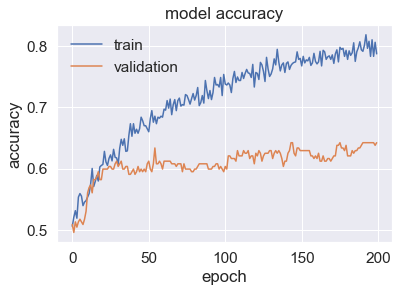

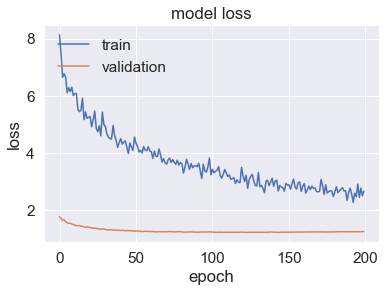

In [68]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
cq_crepe_model.evaluate([test_cq_input, crepe_test_input],y_test_labels)

116/116 [==============================] - 0s 2ms/step


[1.2584783229334602, 0.64224138342101]

#### Confusion Matrix

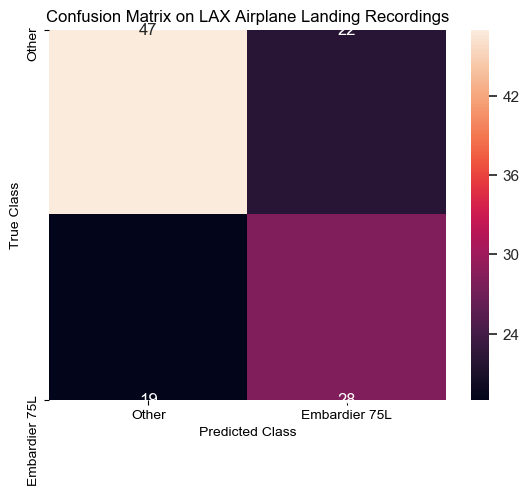

             precision    recall  f1-score   support

        0.0       0.71      0.68      0.70        69
        1.0       0.56      0.60      0.58        47

avg / total       0.65      0.65      0.65       116



In [88]:
plt.style.use('default')
plt.margins(1)
sns.set(font_scale=1)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

                    
preds =np.argmax(cq_crepe_model.predict([test_cq_input, crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix on LAX Airplane Landing Recordings')
ax.xaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.yaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

In [73]:
cm

array([[47, 22],
       [19, 28]], dtype=int64)

# The End